# Estimating the rating of Google Apps

## Project Overview

This project aims to develop a machine learning model to predict the user ratings of Google Play apps based on various app features. The model is built using a dataset containing app details such as category, size, price, and user feedback. The goal is to provide a robust predictive model that can assist developers and stakeholders in understanding the factors that influence app ratings.

Dataset: https://www.kaggle.com/datasets/lava18/google-play-store-apps

## Project Owner: Manuel Contreras
## Date: 28th August 2024

### 1 - Libraries

#### Data Manipulation and Analysis

In [59]:
import pandas as pd
import numpy as np

#### Data Visualization

In [60]:
import seaborn as sns 
import matplotlib.pyplot as plt 

#### Machine Learning and Model Building

In [61]:
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor 

#### Model Evaluation and Selection

In [62]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 

#### Dimensionality Reduction

In [63]:
from sklearn import decomposition 
from sklearn.decomposition import PCA 

#### Display and HTML

In [65]:
from IPython.display import HTML

### 2 - Dataset Import and Feature Computation

In [66]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [67]:
file_path = r'C:\Users\manue\Desktop\DataScience\Datasets\googleplaystore.csv'
df = pd.read_csv(file_path)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [68]:
rows, columns = df.shape
print(f"The dataset has {columns} columns and {rows} rows.")

The dataset has 13 columns and 10841 rows.


In [69]:
column_names = df.columns.values
column_names

array(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'], dtype=object)

### 3 - Data Cleaning

#### Null Values Processing

In [70]:
# Null values in the dataset
null_values = df.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), 'null_values', 'Null values in the dataset')

# Percentage of missing values for each feature
missing_percentage = (df.isnull().sum() / len(df)) * 100
html_missing_percentage = create_scrollable_table(missing_percentage.to_frame(), 'missing_percentage', 'Percentage of missing values for each feature')

display(HTML(html_null_values + html_missing_percentage))

,0
App,0
Category,0
Rating,1474
Reviews,0
Size,0
Installs,0
Type,1
Price,0
Content Rating,1
Genres,0


In [71]:
# If the null values were to be eliminated, we would be missing 15% of the information, which is not much, so it is decided to drop them.
df.dropna(inplace=True)

rows, columns = df.shape
print(f"The dataset after dropping the null values has {columns} columns and {rows} rows.")

The dataset after dropping the null values has 13 columns and 9360 rows.


In [72]:
# There are some NaN string values that will bug the algorithm. To process them, first they need to be converted to actual np.nan values
df.replace('NaN', np.nan, inplace=True)

# Now check for NaN values in each column
nan_counts = df.isnull().sum()
print(nan_counts)

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64


#### Elimination of Duplicates

In [73]:
duplicates = df.duplicated().sum()
print(f"There are {duplicates} duplicated rows.")

There are 474 duplicated rows.


In [74]:
# Remove duplicate rows while keeping the first occurrence and modify the DataFrame in place
df.drop_duplicates(inplace=True)

rows, columns = df.shape
print(f"The dataset after dropping the null values and eliminating duplicates has {columns} columns and {rows} rows.")

The dataset after dropping the null values and eliminating duplicates has 13 columns and 8886 rows.


#### Feature Engineering and Data Type Correction

In [75]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Several variables in the dataset have the potential to provide greater insights if they are properly processed and converted to numerical formats. Variables such as Size, Reviews, and Installs, for example, which are currently stored as object types, need to be process to ensure they are accurately represented and contribute effectively to the analysis.

In [76]:
# 'Reviews' column needs to be converted to numeric and symbols are to be eliminated
df['Reviews'] = pd.to_numeric(df['Reviews'].str.replace(',', ''), errors='coerce')

In [77]:
# 'Last Updated' column to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

In [78]:
# dollar signs and commas from the 'Price' column need to b removed
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '')

# 'Price' column needs to be converted numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df.rename(columns={'Price': 'Price($)'}, inplace=True)

In [79]:
#Installs
q_installs = len(df['Installs'].unique()) 
print("\n", df['Installs'].unique())


 ['10,000+' '500,000+' '5,000,000+' '50,000,000+' '100,000+' '50,000+'
 '1,000,000+' '10,000,000+' '5,000+' '100,000,000+' '1,000,000,000+'
 '1,000+' '500,000,000+' '100+' '500+' '10+' '5+' '50+' '1+']


In [80]:
df['Installs'] = df['Installs'].str.replace(',','')
df['Installs'] = df['Installs'].str.replace('+','')
df = df.astype({"Installs": int})

In [81]:
# Size
q_size = len(df['Size'].unique())  # Number of unique values in 'Size'
print(f'There are a total of {q_size} unique values in "Size"\n')
print("\n", df['Size'].unique())

# Number of rows in the DataFrame
rows = np.shape(df)[0]
print(f'Rows: {rows}')

There are a total of 413 unique values in "Size"


 ['19M' '14M' '8.7M' '25M' '2.8M' '5.6M' '29M' '33M' '3.1M' '28M' '12M'
 '20M' '21M' '37M' '5.5M' '17M' '39M' '31M' '4.2M' '23M' '6.0M' '6.1M'
 '4.6M' '9.2M' '5.2M' '11M' '24M' 'Varies with device' '9.4M' '15M' '10M'
 '1.2M' '26M' '8.0M' '7.9M' '56M' '57M' '35M' '54M' '201k' '3.6M' '5.7M'
 '8.6M' '2.4M' '27M' '2.7M' '2.5M' '7.0M' '16M' '3.4M' '8.9M' '3.9M'
 '2.9M' '38M' '32M' '5.4M' '18M' '1.1M' '2.2M' '4.5M' '9.8M' '52M' '9.0M'
 '6.7M' '30M' '2.6M' '7.1M' '22M' '6.4M' '3.2M' '8.2M' '4.9M' '9.5M'
 '5.0M' '5.9M' '13M' '73M' '6.8M' '3.5M' '4.0M' '2.3M' '2.1M' '42M' '9.1M'
 '55M' '23k' '7.3M' '6.5M' '1.5M' '7.5M' '51M' '41M' '48M' '8.5M' '46M'
 '8.3M' '4.3M' '4.7M' '3.3M' '40M' '7.8M' '8.8M' '6.6M' '5.1M' '61M' '66M'
 '79k' '8.4M' '3.7M' '118k' '44M' '695k' '1.6M' '6.2M' '53M' '1.4M' '3.0M'
 '7.2M' '5.8M' '3.8M' '9.6M' '45M' '63M' '49M' '77M' '4.4M' '70M' '9.3M'
 '8.1M' '36M' '6.9M' '7.4M' '84M' '97M' '2.0M' '1.9M' '1.8M' '5.3M' '47M'
 '5

In [82]:
count_varies = df[df['Size'] == 'Varies with device'].shape[0]
print(f"There are {count_varies} entries where the Size is 'Varies with device'.")

There are 1468 entries where the Size is 'Varies with device'.


In [83]:
df['Size'] = df['Size'].replace('Varies with device', np.nan)

In [84]:
# 'k' and 'M' need to be eliminated
output = df['Size'].replace(r'[kM]', '', regex=True).astype(float)  # Integer values without 'k'/'M'
print(output, '\n')
print(output.value_counts())

0        19.0
1        14.0
2         8.7
3        25.0
4         2.8
         ... 
10834     2.6
10836    53.0
10837     3.6
10839     NaN
10840    19.0
Name: Size, Length: 8886, dtype: float64 

Size
14.0     154
13.0     152
12.0     151
15.0     149
11.0     149
        ... 
383.0      1
454.0      1
442.0      1
842.0      1
619.0      1
Name: count, Length: 376, dtype: int64


In [85]:
# 'k' and 'M' groups to be extracted
output = df['Size'].str.extract(r'([kM])', expand=False)
print(output, '\n')
print(output.value_counts())

0          M
1          M
2          M
3          M
4          M
        ... 
10834      M
10836      M
10837      M
10839    NaN
10840      M
Name: Size, Length: 8886, dtype: object 

Size
M    7162
k     256
Name: count, dtype: int64


In [86]:
# NaNs are replaced to 1 to avoid losing records
output = df['Size'].str.extract(r'([kM])', expand=False).fillna(1)
print(output, '\n')
print(output.value_counts())

0        M
1        M
2        M
3        M
4        M
        ..
10834    M
10836    M
10837    M
10839    1
10840    M
Name: Size, Length: 8886, dtype: object 

Size
M    7162
1    1468
k     256
Name: count, dtype: int64


In [87]:
# 'k' = 10**-3 and 'M' = 1 are standardized
output = df['Size'].str.extract(r'([kM])', expand=False).fillna(1)\
    .replace(['k', 'M'], [10**-3, 1]).astype(float)

print(output.value_counts())

Size
1.000    8630
0.001     256
Name: count, dtype: int64


C:\Users\manue\AppData\Local\Temp\ipykernel_17228\3282673472.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['k', 'M'], [10**-3, 1]).astype(float)


In [88]:
# Combine everything
df['Size'] = (df['Size'].replace(r'[kM]', '', regex=True).astype(float) * \
              df['Size'].str.extract(r'([kM])', expand=False)
              .fillna(1)
              .replace(['k', 'M'], [10**-3, 1]).astype(float))
df['Size']

C:\Users\manue\AppData\Local\Temp\ipykernel_17228\3626643151.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['k', 'M'], [10**-3, 1]).astype(float))


0        19.0
1        14.0
2         8.7
3        25.0
4         2.8
         ... 
10834     2.6
10836    53.0
10837     3.6
10839     NaN
10840    19.0
Name: Size, Length: 8886, dtype: float64

In [89]:
# records with 'Varies with device' (now NaN) are replaced with the mean size by category
df['Size'].fillna(df.groupby('Genres')['Size'].transform('mean'), inplace=True)

In [90]:
# Convert to float
df['Size'] = df['Size'].astype(float)
df['Installs'] = df['Installs'].astype(float)

#### Outliers

In [91]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.describe()

,Rating,Reviews,Size,Installs,Price($)
count,8886.000000,8.886000e+03,8883.000000,8.886000e+03,8886.000000
mean,4.187959,4.730928e+05,22.310514,1.650061e+07,0.963526
std,0.522428,2.906007e+06,21.905367,8.640413e+07,16.194792
min,1.000000,1.000000e+00,0.008500,1.000000e+00,0.000000
25%,4.000000,1.640000e+02,6.300000,1.000000e+04,0.000000
50%,4.300000,4.723000e+03,15.000000,5.000000e+05,0.000000
75%,4.500000,7.131325e+04,30.000000,5.000000e+06,0.000000
max,5.000000,7.815831e+07,100.000000,1.000000e+09,400.000000


In [92]:
# descriptive statistics for the DataFrame 
# Summary statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number])
summary_stats = numerical_features.describe().T
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
Rating,8886.0,4.187959e+00,5.224279e-01,1.0000,4.0,4.3,4.50,5.000000e+00
Reviews,8886.0,4.730928e+05,2.906007e+06,1.0000,164.0,4723.0,71313.25,7.815831e+07
Size,8883.0,2.231051e+01,2.190537e+01,0.0085,6.3,15.0,30.00,1.000000e+02
Installs,8886.0,1.650061e+07,8.640413e+07,1.0000,10000.0,500000.0,5000000.00,1.000000e+09
Price($),8886.0,9.635258e-01,1.619479e+01,0.0000,0.0,0.0,0.00,4.000000e+02


In [93]:
# As it is to be seen, there are some apps with really few reviews, which makes noise to the analysis. They need to be identified and eliminated
# Filter the DataFrame to get rows where 'Reviews' is less than 10
df_less_than_10 = df[df['Reviews'] < 10]

# Count the number of such entries
count_less_than_10 = df_less_than_10.shape[0]
print(f"Number of entries with reviews less than 10: {count_less_than_10}")
df_less_than_10.head()

Number of entries with reviews less than 10: 588


,App,Category,Rating,Reviews,Size,Installs,Type,Price($),Content Rating,Genres,Last Updated,Current Ver,Android Ver
128,Makeup Videos,BEAUTY,3.8,9,3.4,5000.0,Free,0.00,Everyone,Beauty,2018-06-07,1.0,4.0 and up
481,AMBW Dating App: Asian Men Black Women Interra...,DATING,3.5,2,17.0,100.0,Paid,7.99,Mature 17+,Dating,2017-01-21,1.0.1,4.0 and up
602,Transenger – Ts Dating and Chat for Free,DATING,3.6,8,14.0,1000.0,Free,0.00,Mature 17+,Dating,2018-07-29,1.4.0,4.4 and up
608,Chat Kids - Chat Room For Kids,DATING,4.7,6,4.9,100.0,Free,0.00,Mature 17+,Dating,2018-07-24,1.0,4.0.3 and up
611,MouseMingle,DATING,2.7,3,3.9,100.0,Free,0.00,Mature 17+,Dating,2018-07-17,1.0.0,4.4 and up


In [94]:
# Apps with less than 10 reviews are dropped.
df.drop(df[df['Reviews'] < 10].index, inplace=True)

In [95]:
rows, columns = df.shape
print(f"The final dataset has {columns} columns and {rows} rows.")

The final dataset has 13 columns and 8298 rows.


In [96]:
# Elimination of unnecesary columns

In [97]:
df = df.drop(columns=['App', 'Current Ver', 'Android Ver', 'Last Updated'])

### 4 - Exploratory Data Analysis

#### Distribution of Ratings

First and foremost, it is important to see how the ratings, which is what we want to predict, behaves. 

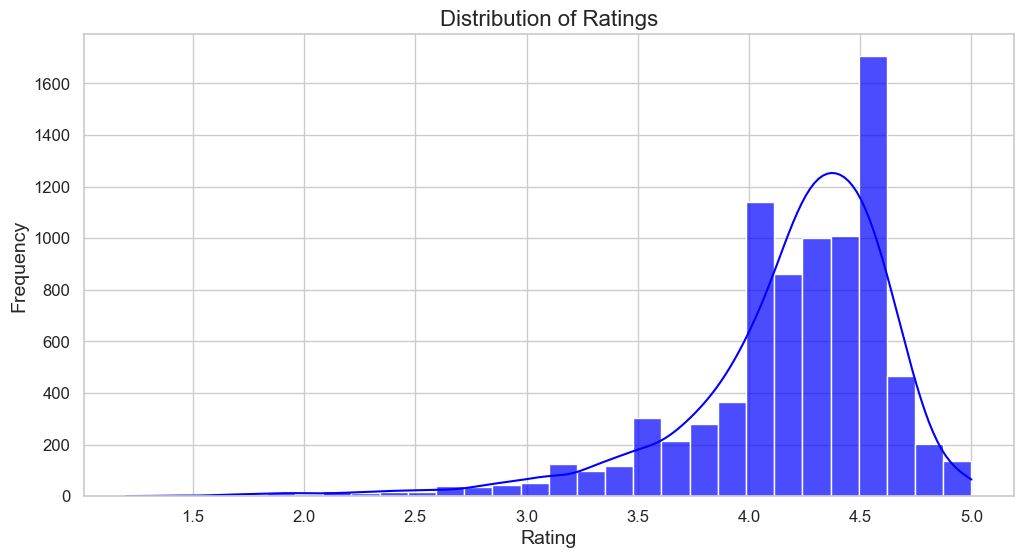

In [233]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(df['Rating'], kde=True, color='blue', bins=30, alpha=0.7)
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

It can be seen that most of them gravitate between a 4.0 and a 4.5 rating.
Does the rating vary based on the category?

#### Average Rating per Category

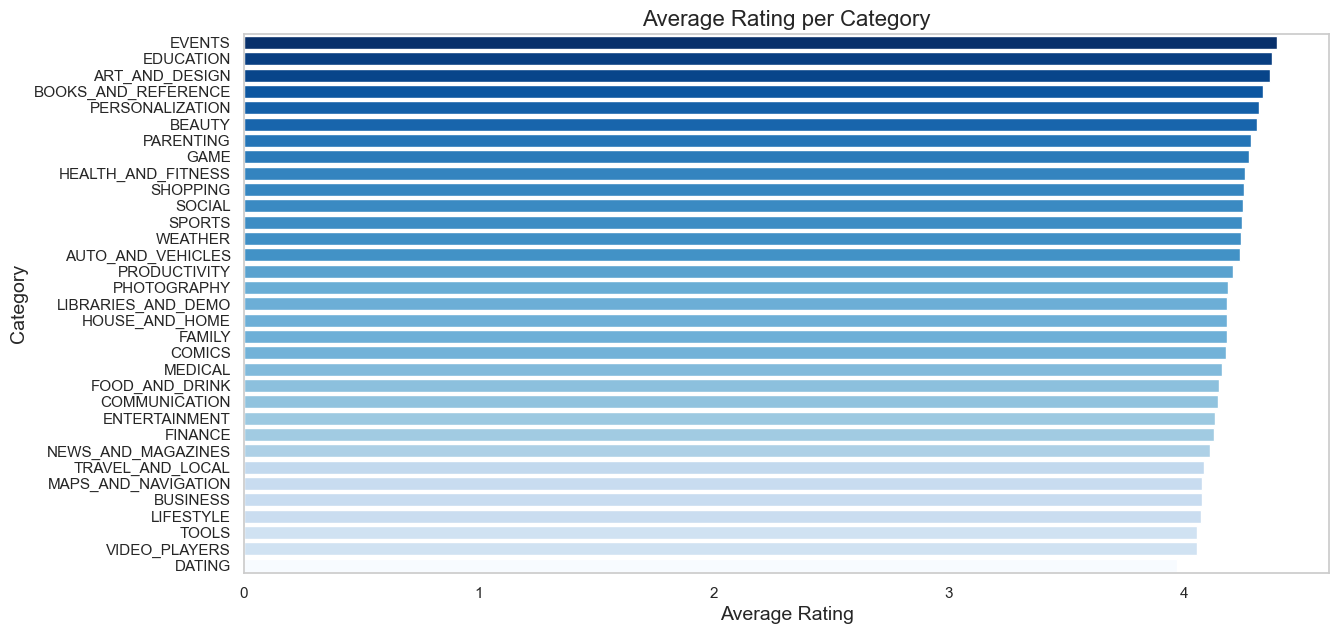

In [234]:
plt.figure(figsize=(14, 7))

# Normalize the average ratings to map to color values
norm = plt.Normalize(average_rating_df['Average Rating'].min(), average_rating_df['Average Rating'].max())
colors = plt.cm.Blues(norm(average_rating_df['Average Rating']))


bars = sns.barplot(x='Average Rating', y='Category', data=average_rating_df)

# custom colors
for bar, color in zip(bars.patches, colors):
    bar.set_facecolor(color)

plt.title('Average Rating per Category', fontsize=16)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Remove grid lines
plt.grid(False)

plt.show()

There is no big variation at all in the ratings based on the category

#### Average Rating by App Type

Does it matter if the App is paid or free?

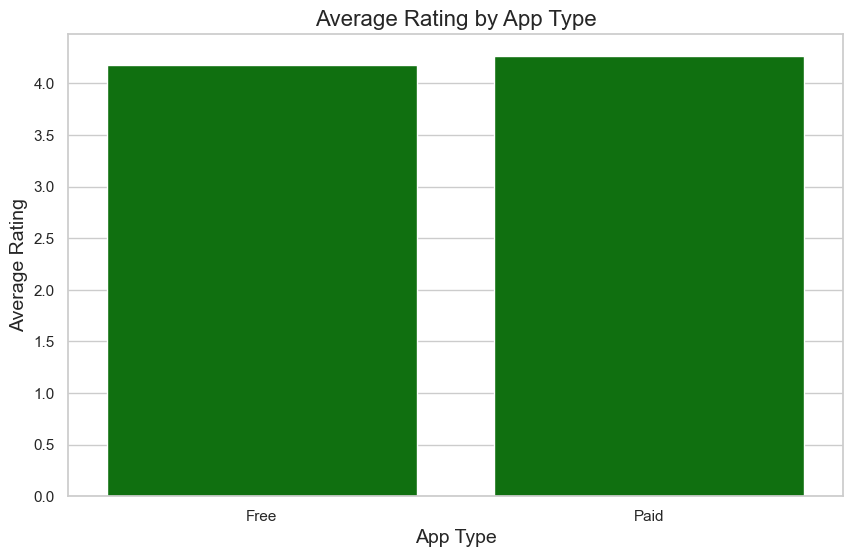

In [235]:
# average rating for each type
average_rating_per_type = df.groupby('Type')['Rating'].mean().reset_index()
average_rating_per_type.columns = ['Type', 'Average Rating']

#  palette
green_palette = sns.color_palette(["#4CAF50", "#81C784"])  # Shades of green

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Average Rating', data=average_rating_per_type, color="Green")
plt.title('Average Rating by App Type', fontsize=16)
plt.xlabel('App Type', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.show()

There is no big variation either.

#### Number of Apps per Category

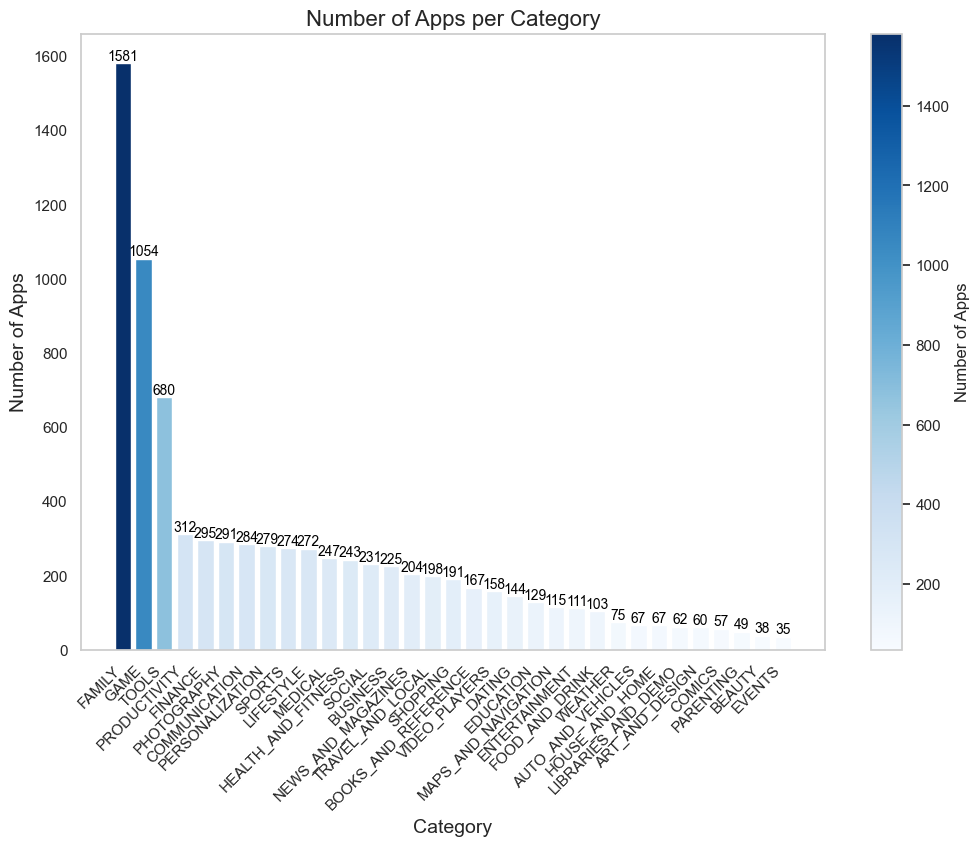

In [236]:
apps_per_category = df['Category'].value_counts()

norm = plt.Normalize(apps_per_category.min(), apps_per_category.max())
colors = plt.cm.Blues(norm(apps_per_category.values))

plt.figure(figsize=(12, 8))
bars = plt.bar(apps_per_category.index, apps_per_category.values, color=colors)
plt.title('Number of Apps per Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Apps', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Remove grid lines
plt.grid(False)

# Numbers on top of each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, int(height), 
             ha='center', va='bottom', fontsize=10, color='black')

# Color bar to indicate the scale
sm = plt.cm.ScalarMappable(cmap='Blues', norm=norm)
sm.set_array([])

# Explicitly specify the axis for the colorbar
plt.colorbar(sm, ax=plt.gca(), label='Number of Apps')

# Display the plot
plt.show()

#### Distribution of Number of Reviews for Apps

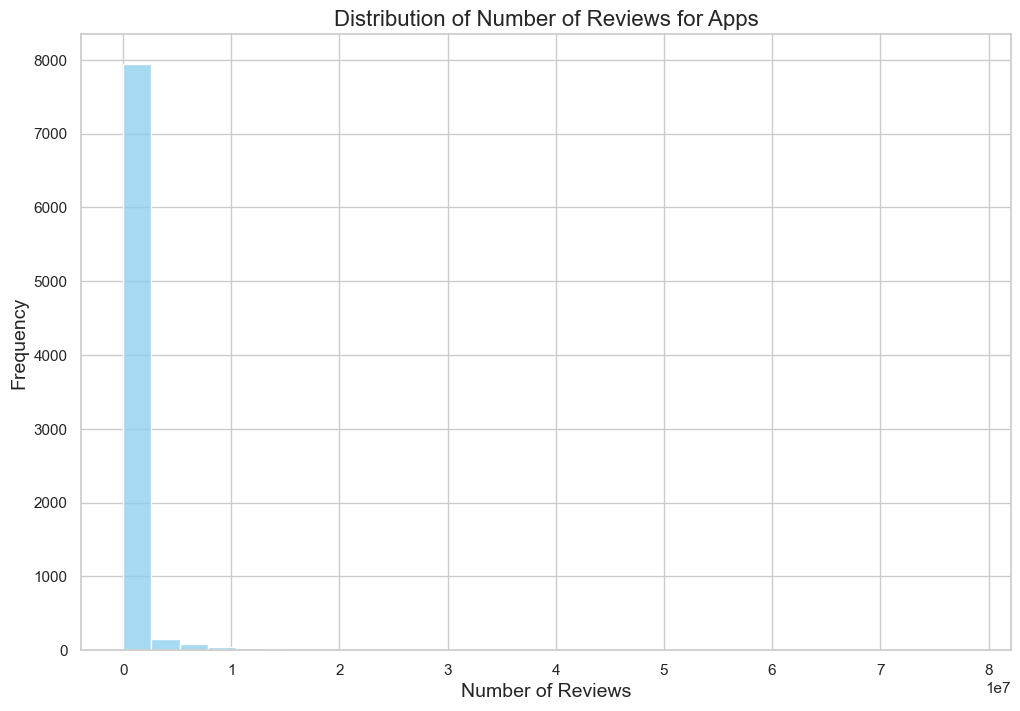

In [237]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Drop rows with NaN values in 'Reviews'
df = df.dropna(subset=['Reviews'])

# histogram of the 'Reviews' column
plt.figure(figsize=(12, 8))
sns.histplot(df['Reviews'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Number of Reviews for Apps', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()


This graph is not really telling. In such cases, it is neccesary to make a change of scales, in this case, we will take the logarithm scale. 

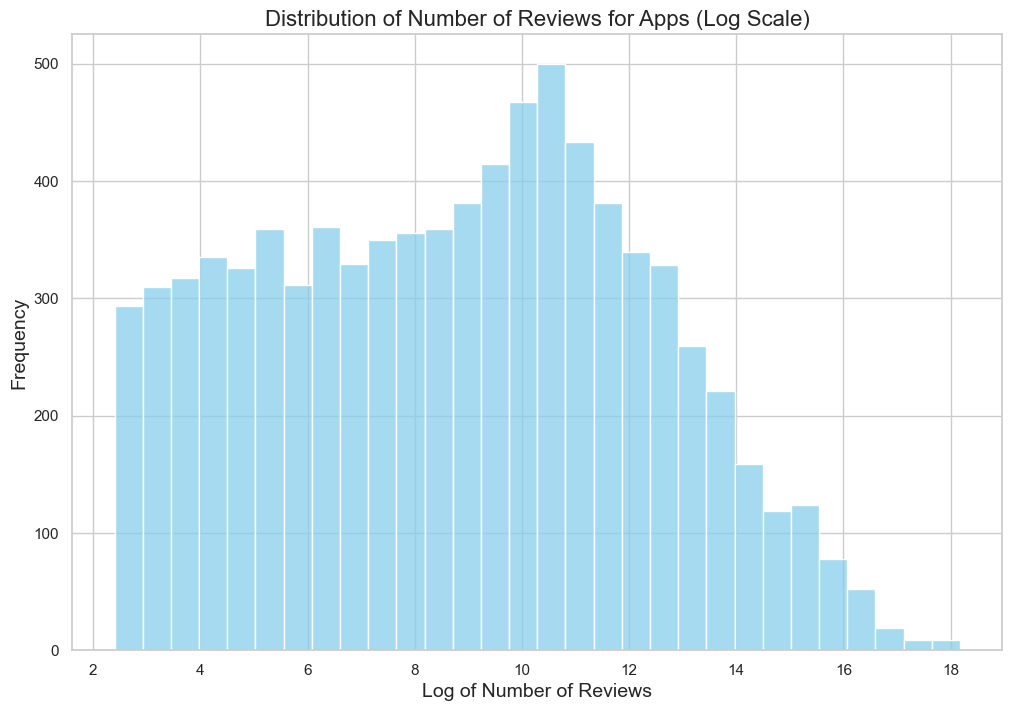

In [238]:
# Drop rows with NaN values in 'Reviews'
df = df.dropna(subset=['Reviews'])

# log transformation (add of a small value to avoid log(0))
df['Log_Reviews'] = np.log1p(df['Reviews'])

# Plot histogram of the log-transformed 'Reviews' column
plt.figure(figsize=(12, 8))
sns.histplot(df['Log_Reviews'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Number of Reviews for Apps (Log Scale)', fontsize=16)
plt.xlabel('Log of Number of Reviews', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.show()

Now it is visible that there are few apps with an enourmous amount of reviews

In [239]:
df[df.Reviews > 10000000].head(15)

,Category,Rating,Reviews,Size,Installs,Type,Price($),Content Rating,Genres,Log_Reviews
335,COMMUNICATION,4.0,56642847,12.338364,1.000000e+09,Free,0.0,Everyone,Communication,17.852276
336,COMMUNICATION,4.4,69119316,12.338364,1.000000e+09,Free,0.0,Everyone,Communication,18.051345
342,COMMUNICATION,4.3,11334799,12.338364,5.000000e+08,Free,0.0,Everyone,Communication,16.243388
378,COMMUNICATION,4.5,17712922,40.000000,5.000000e+08,Free,0.0,Teen,Communication,16.689805
382,COMMUNICATION,4.0,56646578,12.338364,1.000000e+09,Free,0.0,Everyone,Communication,17.852342
385,COMMUNICATION,4.3,11334973,12.338364,5.000000e+08,Free,0.0,Everyone,Communication,16.243404
391,COMMUNICATION,4.1,10484169,12.338364,1.000000e+09,Free,0.0,Everyone,Communication,16.165377
403,COMMUNICATION,4.2,10790289,12.338364,5.000000e+08,Free,0.0,Everyone,Communication,16.194157
406,COMMUNICATION,4.3,12842860,12.338364,1.000000e+08,Free,0.0,Everyone,Communication,16.368299
420,COMMUNICATION,4.5,17714850,40.000000,5.000000e+08,Free,0.0,Teen,Communication,16.689914


As expected all of them are well-known and most people have them on their phones.

This graph is not really helpful, as it does not represent any trend in particular, even if those apps with a high price were to be filtered, still, it would not show anything interesting.
However, and just for the sake of it, lets see what are those apps that cost over 300$.

In [240]:
filtered_apps = df[df['Price($)'] > 300]
sorted_apps = filtered_apps.sort_values(by='Price($)')

sorted_apps

,Category,Rating,Reviews,Size,Installs,Type,Price($),Content Rating,Genres,Log_Reviews
5357,LIFESTYLE,2.9,41,2.900,1000.0,Paid,379.99,Everyone,Lifestyle,3.737670
5366,FAMILY,3.6,217,4.900,10000.0,Paid,389.99,Everyone,Entertainment,5.384495
4362,LIFESTYLE,3.8,718,26.000,10000.0,Paid,399.99,Everyone,Lifestyle,6.577861
5351,LIFESTYLE,3.8,3547,1.800,100000.0,Paid,399.99,Everyone,Lifestyle,8.174139
5354,FAMILY,4.0,856,8.700,10000.0,Paid,399.99,Everyone,Entertainment,6.753438
5356,FINANCE,4.1,1867,4.700,50000.0,Paid,399.99,Everyone,Finance,7.532624
5358,FINANCE,3.8,93,22.000,1000.0,Paid,399.99,Everyone,Finance,4.543295
5359,FINANCE,3.5,472,0.965,5000.0,Paid,399.99,Everyone,Finance,6.159095
5362,FAMILY,4.4,201,2.700,5000.0,Paid,399.99,Everyone,Entertainment,5.308268
5364,FINANCE,4.1,129,2.700,1000.0,Paid,399.99,Teen,Finance,4.867534


#### Dummy Variables

Categorical data, represented as text or categories, cannot be directly processed by these algorithms. By converting them to dummy variables, each category is transformed into a binary (0 or 1) column, allowing the model to interpret and learn from these categorical features effectively

In [241]:
categorical_variables = ['Category', 'Content Rating', 'Genres', 'Type']

# empty list to store dummy DataFrames
dummies_list = []

# Loop through the categorical variables
for col in categorical_variables:
    # dummy variables for each column
    df_dummies = pd.get_dummies(df[col], prefix=col)
    # dummy variables to integers
    df_dummies = df_dummies.astype(int)
    # Append the dummy DataFrame to the list
    dummies_list.append(df_dummies)

# Concatenate all dummy DataFrames along the columns
df_dummies_all = pd.concat(dummies_list, axis=1)
df = df.join(df_dummies_all).drop(columns=categorical_variables)
df.head()
df= df.dropna()

# 5 - Implementation of Different Models

# 5.0 - Lineal Regression

It is a statistical method used to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the data. The goal is to find the best-fitting straight line (or hyperplane) that predicts the dependent variable based on the independent variables.

In [242]:
X = df.drop(columns=['Rating'])
y = df['Rating']

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=48)

Before predicting values, it is neccesary to scale the information. Autoscaler is used to level the playing field for all the features in the dataset. For example, if the height of a person in centimeters with their weight in kilograms were to be compared, it would be hard for the ML algorithm to make sense of it, because the units are so different. By scaling the features, they end up having the same scale, so the model can treat all features fairly and not give too much importance to any one feature just because it has larger numbers. This helps the model learn more effectively and make better predictions.

The scaler is fit with the X_train so it learns the mean and standard deviation (or min and max, depending on the scaling method) from the training data. After this, this scaling is applied to both X_train and X_test to make sure that the model is trained and tested on data that has been scaled in the same way.

In [244]:
# Create and fit the scaler
scaler = StandardScaler().fit(X_train)

In [245]:
xtrain_scal = scaler.transform(X_train) 
xtest_scal = scaler.transform(X_test) 

In [246]:
# Model creation
lr = LinearRegression()

In [247]:
# Model training
lr.fit(xtrain_scal, y_train)

LinearRegression()

In [248]:
ypred_lr = lr.predict(xtest_scal)

In [249]:
# error calculation
np.sqrt(mean_squared_error(y_test, ypred_lr))

0.4707477096527845

Mean Absolute Error (MAE): measures the average magnitude of errors in a set of predictions, without considering their direction (i.e., it averages the absolute differences between observed and predicted values). It is a straightforward way to measure the accuracy of a model. It tells the average absolute error between your predictions and the actual values.

In [250]:
MAE1 = mean_absolute_error(y_test, ypred_lr)
MAE1

0.3318315004885209

Sum of Squared Differences (SSD): is the sum of the squared differences between each observed value and the corresponding predicted value. It quantifies the total deviation of the predicted values from the actual values. It sums up how much predictions deviate from the actual values across all data points.

In [251]:
SSD1= sum((y_test-ypred_lr)**2)
SSD1

459.6054643412919

Residual Standard Error : represents the standard deviation of the residuals (the differences between observed and predicted values). In other words, it indicates how far the data points are from the regression line on average. In easy word, gives  an idea of the typical size of the residuals.

In [252]:
RSE1 = np.sqrt(SSD1/(len(X_test)-160-1))
RSE1

0.4901568842918128

In [253]:
sales_mean = np.mean(y_test)
error1 = RSE1/sales_mean
error1

0.11734254196057203

In [254]:
r2_lr = r2_score(y_test, ypred_lr)
print(f"R-Squared: {r2_lr}")

R-Squared: 0.06976900052662494


Based on the R² value, the model does not seem to be performing well. It's not explaining much of the variance in the target variable (Rating), meaning it's not able to effectively predict the ratings based on the features. Since linear regression assumes a linear relationship between features and the target, other more complex models should be tried (e.g., RandomForestRegressor, GradientBoosting, or Support Vector Regressor) that can capture non-linear patterns.

In [255]:
# Create DataFrame to compare actual vs predicted
comparison_df = pd.DataFrame({
    'Actual Rating': y_test.reset_index(drop=True),
    'Predicted Rating': ypred_lr
})

comparison_df.head(50)

,Actual Rating,Predicted Rating
0,4.1,3.949759
1,3.6,3.882437
2,4.3,3.987845
3,3.5,3.949759
4,4.1,4.103568
5,4.3,4.177542
6,4.2,3.977103
7,4.7,4.308646
8,4.4,4.014273
9,4.7,4.300406


In [256]:
# Define the DataFrame with the correct column names
results_df = pd.DataFrame(columns=['Model', 'Mean Absolute Error', 'Sum of Squared Differences', 'Residual Standard Error', 'Error %', 'R2'])

# Create a new row with values
new_row = pd.DataFrame([{
    'Model': 'Linear Regression', 
    'Mean Absolute Error': MAE1, 
    'Sum of Squared Differences': SSD1,
    'Residual Standard Error': RSE1,
    'Error %': error1,
    'R2': r2_lr
}])

# Ensure new_row has the same columns as results_df and no all-NA columns
new_row = new_row.reindex(columns=results_df.columns)  # Reindex to match columns
new_row = new_row.dropna(axis=1, how='all')  # Drop columns that are all-NA

# Append the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
results_df.head()


C:\Users\manue\AppData\Local\Temp\ipykernel_3460\1836904293.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Model,Mean Absolute Error,Sum of Squared Differences,Residual Standard Error,Error %,R2
0,Linear Regression,0.331832,459.605464,0.490157,0.117343,0.069769


# 5.1 - Decission Tree Regressor

It is a machine learning algorithm used for predicting continuous values. It works by splitting the data into subsets based on feature values, creating a tree-like model of decisions. Each internal node represents a decision based on a feature, and each leaf node represents a predicted value. The tree is built by choosing splits that minimize the variance (or another metric) within each subset, resulting in a model that can handle non-linear relationships and interactions between features.

I start by performing a Grid Search which is a hyperparameter tuning technique used to optimize machine learning models. It explores a predefined set of hyperparameters by training and evaluating the model with all possible combinations. The goal is to find the combination of hyperparameters that bring the best performance, typically evaluated through cross-validation.

In [54]:
param_grid = {
    'min_samples_split': [30, 40,100,150],
    'min_samples_leaf': [3,5, 10, 15, 20],
    'max_depth': [5, 8,10,15]
}

# Create a DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation folds
    scoring='neg_mean_absolute_error',  # or other scoring metric based on your needs
    n_jobs=-1,  # Use all available cores
    verbose=1  # Verbosity level
)

In [74]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10, 15],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [30, 40, 100, 150]},
             scoring='neg_mean_absolute_error', verbose=1)

In [75]:
# best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 100}


In [257]:
regtree = DecisionTreeRegressor(min_samples_split=100, min_samples_leaf=5, max_depth=10, random_state=0)

In [258]:
# Create and fit the scaler
scaler_reg = StandardScaler().fit(X)

In [259]:
X_scal = scaler.transform(X) 

In [260]:
regtree.fit(X_scal,y)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=100,
                      random_state=0)

In [261]:
ypred_rt = regtree.predict(X_scal)

In [262]:
ypred_rt

array([4.09226714, 3.96994681, 4.24223301, ..., 3.94814815, 4.47792208,
       4.37931034])

In [263]:
# Evaluar el modelo
MAE2 = mean_absolute_error(y, ypred_rt)
print(f"Mean Absolute Error: {MAE2}")

Mean Absolute Error: 0.2899798300830427


In [264]:
SSD2 = sum((y-ypred_rt)**2)
SSD2

1433.9596234226788

In [265]:
RSE2 = np.sqrt(SSD2/(len(X_scal)-161))
RSE2

0.419871481417388

In [266]:
sales_mean = np.mean(y)
error2 = RSE2/sales_mean
error2

0.10027535833255788

In [267]:
r2_rt = r2_score(y, ypred_rt)
print(f"R-Squared: {r2_rt}")

R-Squared: 0.23725055791142258


In [268]:
comparison_df = pd.DataFrame({
    'Actual Rating': y,
    'Predicted Rating': ypred_rt
})

In [269]:
comparison_df.head(50)

,Actual Rating,Predicted Rating
0,4.1,4.092267
1,3.9,3.969947
2,4.7,4.242233
3,4.5,4.231373
4,4.3,3.969947
5,4.4,3.969947
6,3.8,3.969947
7,4.1,4.425714
8,4.4,4.251338
9,4.7,4.092267


In [270]:
column_names = X.columns
list(zip(column_names,regtree.feature_importances_))

[('Reviews', 0.331983166879521),
 ('Size', 0.03658093590836948),
 ('Installs', 0.23724631298054924),
 ('Price($)', 0.03367935093192004),
 ('Log_Reviews', 0.17095194252517207),
 ('Category_ART_AND_DESIGN', 0.0),
 ('Category_AUTO_AND_VEHICLES', 0.0),
 ('Category_BEAUTY', 0.0),
 ('Category_BOOKS_AND_REFERENCE', 0.01424091141140286),
 ('Category_BUSINESS', 0.0),
 ('Category_COMICS', 0.0),
 ('Category_COMMUNICATION', 0.0003554725640164119),
 ('Category_DATING', 0.0011687507629126682),
 ('Category_EDUCATION', 0.0),
 ('Category_ENTERTAINMENT', 0.0),
 ('Category_EVENTS', 0.0),
 ('Category_FAMILY', 0.0029726707698907503),
 ('Category_FINANCE', 0.0),
 ('Category_FOOD_AND_DRINK', 0.0),
 ('Category_GAME', 0.0010592456010556199),
 ('Category_HEALTH_AND_FITNESS', 0.005600585939376116),
 ('Category_HOUSE_AND_HOME', 0.0),
 ('Category_LIBRARIES_AND_DEMO', 0.0),
 ('Category_LIFESTYLE', 0.0),
 ('Category_MAPS_AND_NAVIGATION', 0.0),
 ('Category_MEDICAL', 0.0),
 ('Category_NEWS_AND_MAGAZINES', 0.0),
 ('Cat

It is clear to see that Reviews and Size are by far the variables that influence the most

In [271]:
# Create a new row with values
new_row = pd.DataFrame([{
    'Model': 'Decission Tree Regressor', 
    'Mean Absolute Error': MAE2, 
    'Sum of Squared Differences': SSD2,
    'Residual Standard Error': RSE2,
    'Error %': error2,
    'R2': r2_rt
}])

# Ensure new_row has the same columns as results_df and no all-NA columns
new_row = new_row.reindex(columns=results_df.columns)  # Reindex to match columns
new_row = new_row.dropna(axis=1, how='all')  # Drop columns that are all-NA

# Append the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
results_df.head()

,Model,Mean Absolute Error,Sum of Squared Differences,Residual Standard Error,Error %,R2
0,Linear Regression,0.331832,459.605464,0.490157,0.117343,0.069769
1,Decission Tree Regressor,0.289980,1433.959623,0.419871,0.100275,0.237251


# 5.2 - Random Forest Regressor

It uses an ensemble of decision trees to predict continuous values. It averages the predictions from multiple trees to improve accuracy and reduce overfitting, making it robust for regression tasks.

In [156]:
rf = RandomForestRegressor()

In [56]:
param_grid = {
    'n_estimators': [100, 500,1000],        # Number of trees in the forest
    'min_samples_split': [2, 5, 8,15],             # Minimum number of samples required to split an internal node
    'min_samples_leaf': [ 4,10, 20],               # Minimum number of samples required to be at a leaf node
    'random_state': [42]                         # Ensuring reproducibility
}

In [57]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5,                        # 5-fold cross-validation
                           n_jobs=-1,                  # Use all available cores
                           verbose=2,                  # Verbose output during training
                           scoring='neg_mean_squared_error')  # Scoring metric

In [58]:
grid_search.fit(xtrain_scal, y_train)  # Replace X_train and y_train with your dataset

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'min_samples_leaf': [4, 10, 20],
                         'min_samples_split': [2, 5, 8, 15],
                         'n_estimators': [100, 500, 1000],
                         'random_state': [42]},
             scoring='neg_mean_squared_error', verbose=2)

RandomForestRegressor(max_features='sqrt', min_samples_split=15,
                      n_estimators=300, random_state=42)

In [272]:
forest = RandomForestRegressor(max_depth=800, max_features='sqrt', min_samples_split=3,
                      n_estimators=2000, random_state=42)

In [273]:
forest.fit(X_scal,y)

RandomForestRegressor(max_depth=800, max_features='sqrt', min_samples_split=3,
                      n_estimators=2000, random_state=42)

In [274]:
ypred_forest = forest.predict(X_scal)

In [275]:
MAE3 = mean_absolute_error(y, ypred_forest)
print(f"Mean Absolute Error: {MAE3}")

Mean Absolute Error: 0.1329406210210358


In [276]:
SSD3 = sum((y-ypred_forest)**2)
SSD3

323.680595388767

In [277]:
RSE3 = np.sqrt(SSD3/(len(X_scal)-160-1))
RSE3

0.19948316407665292

In [278]:
sales_mean = np.mean(y)
error3 = RSE3/sales_mean
error3

0.047641353710360435

In [279]:
r2_f = r2_score(y, ypred_forest)
print(f"R-Squared: {r2_f}")

R-Squared: 0.8278283505930297


In [280]:
# Create a new row with values
new_row = pd.DataFrame([{
    'Model': 'Random Forest Regressor', 
    'Mean Absolute Error': MAE3, 
    'Sum of Squared Differences': SSD3,
    'Residual Standard Error': RSE3,
    'Error %': error3,
    'R2': r2_f
}])

# Ensure new_row has the same columns as results_df and no all-NA columns
new_row = new_row.reindex(columns=results_df.columns)  # Reindex to match columns
new_row = new_row.dropna(axis=1, how='all')  # Drop columns that are all-NA

# Append the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
results_df.head()

,Model,Mean Absolute Error,Sum of Squared Differences,Residual Standard Error,Error %,R2
0,Linear Regression,0.331832,459.605464,0.490157,0.117343,0.069769
1,Decission Tree Regressor,0.289980,1433.959623,0.419871,0.100275,0.237251
2,Random Forest Regressor,0.132941,323.680595,0.199483,0.047641,0.827828


# 5.3 - Super Vector Machine

 It aims to find a function that approximates the relationship between input features and a continuous target variable. SVR tries to fit the best line within a margin of tolerance (epsilon) around the true values, while also maximizing the margin between the function and the data points. It can handle both linear and non-linear relationships by using different kernel functions.

 Parameters: 

 * C (Regularization Parameter): Controls the trade-off between achieving a low error on the training data and minimizing the model complexity. A high value of C aims to fit the training data as well as possible, potentially leading to overfitting. A low value of C allows for a wider margin and a simpler model, possibly underfitting.

 * Kernel: Defines the function used to transform the input data into a higher-dimensional space where a linear separation might be easier.
   There are many tipes:
      * Linear: No transformation; data is used as-is
      * Polynomial: Maps data into polynomial feature space
      * RBF (Radial Basis Function): Maps data into a higher-dimensional space using Gaussian functions, useful for capturing non-linear relationships.
      * Sigmoid: Uses a sigmoid function to map the data, similar to a neural network.
  
* Gamma (Kernel Coefficient): Defines the influence of a single training example on the decision boundary. A low gamma value means a larger range of influence, making the decision boundary smoother. A high gamma value means a smaller range of influence, leading to a more complex boundary that can fit the training data more closely.

* Epsilon: Specifies the tolerance within which no penalty is given for errors in the training data. The SVR tries to fit the data points within a margin of epsilon. Points within this margin are considered to have no error; points outside the margin contribute to the loss function. A larger epsilon allows for more flexibility in fitting the model, while a smaller epsilon makes the model stricter about fitting the training data.

In [129]:
# Define the parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'rbf'],  # Radial basis function kernel and linear kernel
    'C': [0.1, 1, 10, 100],       # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1, 10],  # Kernel coefficient (for 'rbf' kernel)
    'epsilon': [0.1, 0.2, 0.5, 1]  # Epsilon in the epsilon-SVR model
}


In [ ]:
# Initialize the SVR model
svr = SVR()

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=svr, 
                           param_grid=param_grid, 
                           cv=5,  # Number of folds in cross-validation
                           scoring='neg_mean_squared_error',  # Or any other suitable scoring metric
                           n_jobs=-1,  # Use all available cores
                           verbose=2)  # Verbose output during training

# Fit the GridSearchCV

grid_search.fit(xtrain_scal, y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


In [281]:
svr = SVR(C=10, epsilon=0.2, gamma=10, kernel='linear')

In [282]:
svr.fit(xtrain_scal, y_train)

SVR(C=10, epsilon=0.2, gamma=10, kernel='linear')

In [283]:
Y_pred_svr = svr.predict(xtest_scal)

In [284]:
# Evaluate the model
MAE4 = mean_absolute_error(y_test, Y_pred_svr)
mse = mean_squared_error(y_test, Y_pred_svr)
r2_svr = r2_score(y_test, Y_pred_svr)

# Display the results
print(f"Mean Absolute Error: {MAE4}")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

Mean Absolute Error: 0.31398787708859427
Mean Squared Error: 0.21884456499719696
R-Squared: 0.04465980420577009


In [285]:
new_row = pd.DataFrame([{
    'Model': 'Support Vector Machine', 
    'Mean Absolute Error': MAE4, 
    'Sum of Squared Differences': 'Not Calculated',
    'Residual Standard Error': 'Not Calculated',
    'Error %': 'Not Calculated',
    'R2': r2_svr
}])

# Ensure new_row has the same columns as results_df and no all-NA columns
new_row = new_row.reindex(columns=results_df.columns)  # Reindex to match columns
new_row = new_row.dropna(axis=1, how='all')  # Drop columns that are all-NA

# Append the new row to the results DataFrame
results_df = pd.concat([results_df, new_row], ignore_index=True)

# Display the results DataFrame
results_df.head()

,Model,Mean Absolute Error,Sum of Squared Differences,Residual Standard Error,Error %,R2
0,Linear Regression,0.331832,459.605464,0.490157,0.117343,0.069769
1,Decission Tree Regressor,0.289980,1433.959623,0.419871,0.100275,0.237251
2,Random Forest Regressor,0.132941,323.680595,0.199483,0.047641,0.827828
3,Support Vector Machine,0.313988,Not Calculated,Not Calculated,Not Calculated,0.081350


## 7 - Best Model Selection and Interpretation of its Results

The model used is **Random Forest Regressor**. 

Result Interpretation: 

* Mean Absolute Error (MAE): With an MAE of ** 0.132941 **, on average, the model’s predictions are off by 0.12 units from the actual values. Since the target values range from 1 to 5, this is quite a low error, suggesting that the model’s predictions are quite accurate.

* Residual Standard Error (RSE):This value indicates that, on average, the predictions deviate by about 0.199 units from the true values. Given your range (1 to 5), this is relatively low, suggesting that your model performs well in terms of prediction accuracy.
